In [ ]:
import tensorflow as tf  
from tensorflow import keras
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
(x_train, y_train),(x_test, y_test) = tf.keras.datasets.mnist.load_data()  # loads the popular "mnist" training dataset

x_train = x_train/255.0  # scales the data. pixel values range from 0 to 255, so this makes it range 0 to 1
x_test = x_test/255.0  # scales the data. pixel values range from 0 to 255, so this makes it range 0 to 1


11493376/11490434 [==============================] - 0s 0us/step


In [ ]:
encoder_input = keras.Input(shape=(28, 28, 1), name='img')
x = keras.layers.Flatten()(encoder_input)
encoder_output = keras.layers.Dense(25, activation="relu")(x)

encoder = keras.Model(encoder_input, encoder_output, name='encoder')

decoder_input = keras.layers.Dense(25, activation="relu")(encoder_output)
x = keras.layers.Dense(784, activation="relu")(decoder_input)
decoder_output = keras.layers.Reshape((28, 28, 1))(x)

opt = tf.keras.optimizers.Adam(lr=0.001, decay=1e-6)

autoencoder = keras.Model(encoder_input, decoder_output, name='autoencoder')
autoencoder.summary()

autoencoder.compile(opt, loss='mse')


Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img (InputLayer)             [(None, 28, 28, 1)]       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 25)                19625     
_________________________________________________________________
dense_4 (Dense)              (None, 25)                650       
_________________________________________________________________
dense_5 (Dense)              (None, 784)               20384     
_________________________________________________________________
reshape_1 (Reshape)          (None, 28, 28, 1)         0         
Total params: 40,659
Trainable params: 40,659
Non-trainable params: 0
___________________________________________________

In [ ]:
epochs=3

for epoch in range(epochs):

    history = autoencoder.fit(
      x_train,
      x_train,
      epochs=1, 
      batch_size=32, validation_split=0.10
        )   
    autoencoder.save(f"models/AE-{epoch+1}.model")

1688/1688 [==============================] - 4s 2ms/step - loss: 0.0431 - val_loss: 0.0249
INFO:tensorflow:Assets written to: models/AE-1.model/assets
1688/1688 [==============================] - 3s 2ms/step - loss: 0.0239 - val_loss: 0.0229
INFO:tensorflow:Assets written to: models/AE-2.model/assets
1688/1688 [==============================] - 3s 2ms/step - loss: 0.0227 - val_loss: 0.0221
INFO:tensorflow:Assets written to: models/AE-3.model/assets


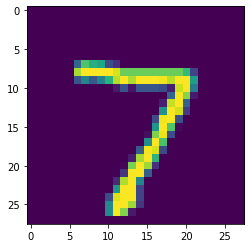

In [ ]:
plt.figure()
plt.imshow(x_test[0])

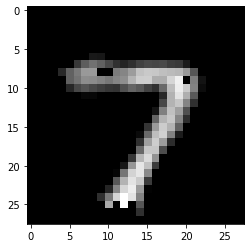

In [ ]:
ae_out = autoencoder.predict([ x_test[0].reshape(-1, 28, 28, 1) ])
img = ae_out[0]  # predict is done on a vector, and returns a vector, even if its just 1 element, so we still need to grab the 0th
plt.imshow(ae_out[0].reshape(-1,28), cmap="gray")

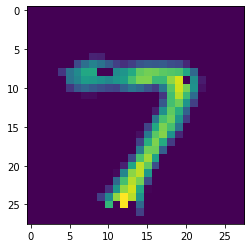

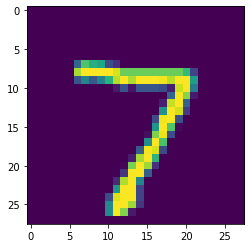

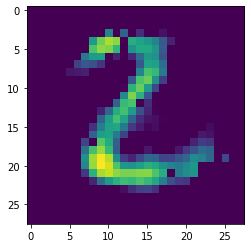

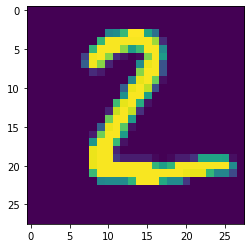

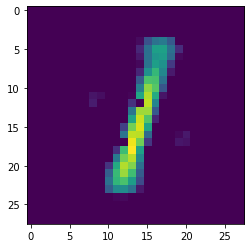

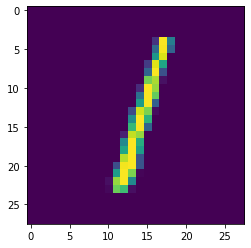

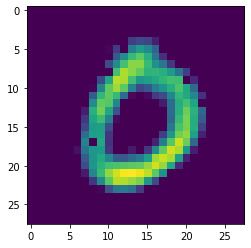

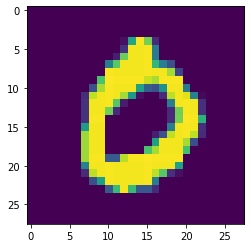

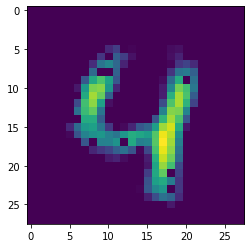

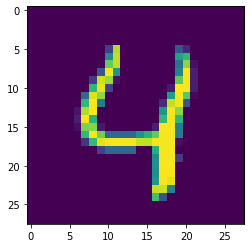

In [ ]:
for d in x_test[:5]:  # just show 5 examples, feel free to show all or however many you want!

    ae_out = autoencoder.predict([ d.reshape(-1, 28, 28, 1) ])
    img = ae_out[0]
    plt.figure()
    plt.imshow(img.reshape(-1, 28))
    plt.figure()
    plt.imshow(np.array(d))

## Save model / quantize

In [ ]:
autoencoder.save("autoenc.h5")

In [ ]:
def repr_dataset():
  for t in x_train:
    image = np.expand_dims(t, axis=1) 
    image = image.reshape(1, 28, 28, 1)
    yield [image.astype(np.float32)]

In [ ]:
model = tf.keras.models.load_model('autoenc.h5')
converter = tf.lite.TFLiteConverter.from_keras_model(model)

converter.allow_custom_ops = True 
converter.experimental_new_converter = False
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8] # tf.lite.OpsSet.TFLITE_BUILTINS_INT8, 
converter.quantized_input_stats = {"normalized_input_image_tensor": [127.0, 127.0]}
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8
converter.representative_dataset = repr_dataset

tflite_model = converter.convert()
open("converted_model.tflite", "wb").write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpb4qdknbf/assets


INFO:tensorflow:Assets written to: /tmp/tmpb4qdknbf/assets


45776

In [ ]:
! curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | sudo apt-key add -

! echo "deb https://packages.cloud.google.com/apt coral-edgetpu-stable main" | sudo tee /etc/apt/sources.list.d/coral-edgetpu.list

! sudo apt-get update

! sudo apt-get install edgetpu-compiler	

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2537  100  2537    0     0  27879      0 --:--:-- --:--:-- --:--:-- 28188
OK
deb https://packages.cloud.google.com/apt coral-edgetpu-stable main
Ign:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:2 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Get:4 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:5 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Hit:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:7 https://packages.cloud.google.com/apt coral-edgetpu-stable InRelease [6,722 B]
Get:9 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubunt

In [ ]:
! edgetpu_compiler -s "converted_model.tflite"

Edge TPU Compiler version 15.0.340273435

Model compiled successfully in 62 ms.

Input model: converted_model.tflite
Input size: 44.70KiB
Output model: converted_model_edgetpu.tflite
Output size: 116.53KiB
On-chip memory used for caching model parameters: 82.00KiB
On-chip memory remaining for caching model parameters: 7.78MiB
Off-chip memory used for streaming uncached model parameters: 0.00B
Number of Edge TPU subgraphs: 1
Total number of operations: 6
Operation log: converted_model_edgetpu.log

Operator                       Count      Status

QUANTIZE                       2          Mapped to Edge TPU
RESHAPE                        1          Mapped to Edge TPU
FULLY_CONNECTED                3          Mapped to Edge TPU
